# ResNet

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline

See MIT License in https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 Online.


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, RepeatedKFold

import os
import pathlib
import time
from datetime import datetime

np.random.seed(813306)

# User inputs ##

flist = ['GunPoint'] # List dataset directory names.
batch_size = 64 # Wang: int(min(x_train.shape[0]/10, 16)) 
nb_epochs = 1500 # Wang: 1500
k = 10 # For k-fold cross validation. If k=1, the original test-train split is used.
m = 10 # Number of repetitions of k-fold cross validation (if k>1).
k_fold_seed = 87
tensorboard = True # Set to True to write logs for use by TensorBoard
early_stopping = False # Not yet ready for use # Use early stopping.
# Directories
fdir = '../data'  
logs_dir = '../logs'
tensorboard_dir = '../logs/tensorboard'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp
tensorboard_dir = tensorboard_dir +'/' + timestamp

In [1]:
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = Input(shape=(input_shape))
    conv_x = keras.layers.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, padding='same')(conv_x)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,padding='same')(x)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, padding='same')(x1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,padding='same')(x1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = keras.layers.add([shortcut_y, conv_z])
    y = Activation('relu')(y)
     
    full = keras.layers.GlobalAveragePooling2D()(y)   
    out = Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out
 
       
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
   


    
    
def train_model(fname, x_train, y_train, x_test, y_test, label="0"):
    print('Running dataset', fname)
    nb_classes = len(np.unique(y_test))
     
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
     
     
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
      
    x_test = (x_test - x_train_mean)/(x_train_std)
    x_train = x_train.reshape(x_train.shape + (1,1,))
    x_test = x_test.reshape(x_test.shape + (1,1,))
     
     
    x , y = build_resnet(x_train.shape[1:], 64, nb_classes)
    model = Model(x, y)
    #print(model.summary())
    
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                      patience=50, min_lr=0.0001) 
    callbacks = [reduce_lr]
    if tensorboard:
        tb_dir = tensorboard_dir+'/'+fname+'_'+label
        pathlib.Path(tb_dir).mkdir(parents=True, exist_ok=True) 
        print('Tensorboard logs in', tb_dir)
        callbacks.append(keras.callbacks.TensorBoard(log_dir=tb_dir, histogram_freq=0))

    if early_stopping:
        early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, 
         patience=10) # when tf updates keras, use restore_best_weights instead of ModelCheckPoint
        model_save = keras.callbacks.ModelCheckpoint(logs_dir+'/temp.h5', monitor='val_acc', 
            save_best_only=True, save_weights_only=True)
        callbacks.append(early_stop)
        callbacks.append(model_save)

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=1, validation_data=(x_test, Y_test), callbacks=callbacks)
    end = time.time()
    log = pd.DataFrame(hist.history)  
    
    if not early_stopping:
        # Print and save results. Print the testing results which has the lowest training loss.
        print('Training complete on', fname)
        duration_minutes = str(round((end-start)/60))
        print('Training time ', end-start, 'seconds, which is about', duration_minutes, 'minutes.')    
        print('Selected the test result with the lowest training loss. Loss and validation accuracy are -')
        idx = log['loss'].idxmin()
        loss = log.loc[idx]['loss']
        val_acc = log.loc[idx]['val_acc']
        print(loss, val_acc, 'at index', str(idx), ' (epoch ', str(idx+1), ')')
        summary = '|' + label + '  |'+str(loss)+'  |'+str(val_acc)+' |'+str(idx)+' |'+ duration_minutes + 'mins  |'
        summary_csv = label+','+str(loss)+','+str(val_acc)+','+str(idx)+','+ duration_minutes 
    
    else:
        model.load_weights(logs_dir+'/temp.h5')
        eval = model.evaluate(metrics=['loss','accuracy'])
        print('From model.evaluate()')
        print(eval['loss'], eval['accuracy'])
    
    # Save summary file and log file.
    print('Tensorboard logs in', tb_dir)
    with open(logs_dir+'/'+fname+'/resnet_summary.csv', 'a+') as f:
        f.write(summary_csv)
        f.write('\n')
        print('Added summary row to ', logs_dir+'/'+fname+'/resnet_summary.csv')  
    print('Saving logs to',logs_dir+'/'+fname+'/history_'+label+'.csv')
    log.to_csv(logs_dir+'/'+fname+'/history_'+label+'.csv')
    
    return summary, model


# main
results = []
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = RepeatedKFold(n_splits=k, n_repeats=m, random_state=k_fold_seed)
        count = 0
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            summary, model = train_model(fname, x_train, y_train, x_test, y_test, str(count))
            results.append(summary)
            count = count + 1
    else:
        summary, model = train_model(fname, x_train, y_train, x_test, y_test)
        results.append(summary)
        
print('DONE')
print(fname, timestamp)
for each in results:
    print(each)
#print('Example prediction probabilities')
#y_predict = model.predict_proba(x_test)            
#for yp in y_predict[1:20]:
#    print(yp)

Running dataset GunPoint
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
build conv_x
build conv_y
build conv_z
Merging skip connection
        -- model was built.
Tensorboard logs in ../logs/tensorboard/2018-12-23T08:18/GunPoint_98
Train on 180 samples, validate on 20 samples
Epoch 1/1500
180/180 [==============================] - 3s 19ms/step - loss: 1.0204 - acc: 0.4722 - val_loss: 0.6932 - val_acc: 0.4500
Epoch 2/1500
180/180 [==============================] - 0s 896us/step - loss: 0.5742 - acc: 0.6778 - val_loss: 0.6928 - val_acc: 0.4000
Epoch 3/1500
180/180 [==============================] - 0s 928us/step - loss: 0.4606 - acc: 0.7611 - val_loss: 0.6903 - val_acc: 0.6500
Epoch 4/1500
180/180 [==============================] - 0s 912us/step - loss: 0.3695 - acc: 0.8556 - val_loss: 0.6869 - val_acc: 0.5500
Epoch 5/1500
180/180 [==============================] - 0s 900us/step - loss: 0.2841 - acc: 0.8889 - 

180/180 [==============================] - 0s 871us/step - loss: 6.6774e-04 - acc: 1.0000 - val_loss: 3.9552 - val_acc: 0.6000
Epoch 118/1500
180/180 [==============================] - 0s 897us/step - loss: 6.5959e-04 - acc: 1.0000 - val_loss: 3.9717 - val_acc: 0.6000
Epoch 119/1500
180/180 [==============================] - 0s 871us/step - loss: 4.2357e-04 - acc: 1.0000 - val_loss: 3.9782 - val_acc: 0.6500
Epoch 120/1500
180/180 [==============================] - 0s 844us/step - loss: 3.7819e-04 - acc: 1.0000 - val_loss: 3.9654 - val_acc: 0.6500
Epoch 121/1500
180/180 [==============================] - 0s 884us/step - loss: 6.5515e-04 - acc: 1.0000 - val_loss: 3.9383 - val_acc: 0.6500
Epoch 122/1500
180/180 [==============================] - 0s 928us/step - loss: 3.8834e-04 - acc: 1.0000 - val_loss: 3.8955 - val_acc: 0.6500
Epoch 123/1500
180/180 [==============================] - 0s 876us/step - loss: 5.5632e-04 - acc: 1.0000 - val_loss: 3.8437 - val_acc: 0.6500
Epoch 124/1500
180/18

Epoch 175/1500
180/180 [==============================] - 0s 821us/step - loss: 1.6551e-04 - acc: 1.0000 - val_loss: 1.1420 - val_acc: 0.7000
Epoch 176/1500
180/180 [==============================] - 0s 853us/step - loss: 1.2428e-04 - acc: 1.0000 - val_loss: 1.1000 - val_acc: 0.7000
Epoch 177/1500
180/180 [==============================] - 0s 878us/step - loss: 1.3431e-04 - acc: 1.0000 - val_loss: 1.0599 - val_acc: 0.7000
Epoch 178/1500
180/180 [==============================] - 0s 861us/step - loss: 1.5721e-04 - acc: 1.0000 - val_loss: 1.0224 - val_acc: 0.7000
Epoch 179/1500
180/180 [==============================] - 0s 860us/step - loss: 3.0706e-04 - acc: 1.0000 - val_loss: 1.0094 - val_acc: 0.7000
Epoch 180/1500
180/180 [==============================] - 0s 823us/step - loss: 1.2318e-04 - acc: 1.0000 - val_loss: 0.9784 - val_acc: 0.7000
Epoch 181/1500
180/180 [==============================] - 0s 850us/step - loss: 3.2141e-04 - acc: 1.0000 - val_loss: 0.9298 - val_acc: 0.7000
Epoch 

Epoch 233/1500
180/180 [==============================] - 0s 884us/step - loss: 9.8695e-05 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 234/1500
180/180 [==============================] - 0s 886us/step - loss: 9.1038e-05 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 235/1500
180/180 [==============================] - 0s 890us/step - loss: 2.1484e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 236/1500
180/180 [==============================] - 0s 892us/step - loss: 7.2935e-05 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 237/1500
180/180 [==============================] - 0s 872us/step - loss: 1.3224e-04 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 238/1500
180/180 [==============================] - 0s 897us/step - loss: 9.5993e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 239/1500
180/180 [==============================] - 0s 855us/step - loss: 2.2285e-04 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 

180/180 [==============================] - 0s 904us/step - loss: 1.9648e-04 - acc: 1.0000 - val_loss: 9.1494e-04 - val_acc: 1.0000
Epoch 346/1500
180/180 [==============================] - 0s 904us/step - loss: 8.4780e-05 - acc: 1.0000 - val_loss: 8.7825e-04 - val_acc: 1.0000
Epoch 347/1500
180/180 [==============================] - 0s 875us/step - loss: 7.6622e-05 - acc: 1.0000 - val_loss: 8.5789e-04 - val_acc: 1.0000
Epoch 348/1500
180/180 [==============================] - 0s 869us/step - loss: 1.6004e-04 - acc: 1.0000 - val_loss: 8.5905e-04 - val_acc: 1.0000
Epoch 349/1500
180/180 [==============================] - 0s 896us/step - loss: 4.4334e-05 - acc: 1.0000 - val_loss: 8.5809e-04 - val_acc: 1.0000
Epoch 350/1500
180/180 [==============================] - 0s 862us/step - loss: 6.8597e-05 - acc: 1.0000 - val_loss: 8.6257e-04 - val_acc: 1.0000
Epoch 351/1500
180/180 [==============================] - 0s 863us/step - loss: 4.1481e-04 - acc: 1.0000 - val_loss: 8.0895e-04 - val_acc: 

180/180 [==============================] - 0s 889us/step - loss: 4.3923e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 403/1500
180/180 [==============================] - 0s 870us/step - loss: 4.5971e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 404/1500
180/180 [==============================] - 0s 907us/step - loss: 5.2148e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 405/1500
180/180 [==============================] - 0s 867us/step - loss: 1.2267e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 406/1500
180/180 [==============================] - 0s 911us/step - loss: 4.6755e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 407/1500
180/180 [==============================] - 0s 895us/step - loss: 8.1260e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 408/1500
180/180 [==============================] - 0s 900us/step - loss: 5.4334e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 409/1500
180/18

Epoch 517/1500
180/180 [==============================] - 0s 917us/step - loss: 4.2377e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 518/1500
180/180 [==============================] - 0s 883us/step - loss: 7.8103e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 519/1500
180/180 [==============================] - 0s 876us/step - loss: 4.9037e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 520/1500
180/180 [==============================] - 0s 874us/step - loss: 6.1068e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 521/1500
180/180 [==============================] - 0s 914us/step - loss: 4.4050e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 522/1500
180/180 [==============================] - 0s 900us/step - loss: 5.8459e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 523/1500
180/180 [==============================] - 0s 923us/step - loss: 5.9853e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 

180/180 [==============================] - 0s 949us/step - loss: 3.5625e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 632/1500
180/180 [==============================] - 0s 919us/step - loss: 4.5480e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 633/1500
180/180 [==============================] - 0s 902us/step - loss: 4.8060e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 634/1500
180/180 [==============================] - 0s 919us/step - loss: 4.2927e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 635/1500
180/180 [==============================] - 0s 919us/step - loss: 6.5016e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 636/1500
180/180 [==============================] - 0s 942us/step - loss: 7.1204e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 637/1500
180/180 [==============================] - 0s 928us/step - loss: 4.6697e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 638/1500
180/18

180/180 [==============================] - 0s 850us/step - loss: 1.2203e-04 - acc: 1.0000 - val_loss: 8.6476e-04 - val_acc: 1.0000
Epoch 744/1500
180/180 [==============================] - 0s 892us/step - loss: 4.7801e-05 - acc: 1.0000 - val_loss: 8.7731e-04 - val_acc: 1.0000
Epoch 745/1500
180/180 [==============================] - 0s 923us/step - loss: 2.9915e-05 - acc: 1.0000 - val_loss: 8.9229e-04 - val_acc: 1.0000
Epoch 746/1500
180/180 [==============================] - 0s 911us/step - loss: 8.2717e-05 - acc: 1.0000 - val_loss: 9.0114e-04 - val_acc: 1.0000
Epoch 747/1500
180/180 [==============================] - 0s 889us/step - loss: 4.4359e-05 - acc: 1.0000 - val_loss: 8.9417e-04 - val_acc: 1.0000
Epoch 748/1500
180/180 [==============================] - 0s 914us/step - loss: 3.7457e-05 - acc: 1.0000 - val_loss: 8.8251e-04 - val_acc: 1.0000
Epoch 749/1500
180/180 [==============================] - 0s 892us/step - loss: 4.2243e-05 - acc: 1.0000 - val_loss: 8.6870e-04 - val_acc: 

180/180 [==============================] - 0s 910us/step - loss: 6.5384e-05 - acc: 1.0000 - val_loss: 6.1862e-04 - val_acc: 1.0000
Epoch 856/1500
180/180 [==============================] - 0s 897us/step - loss: 6.9310e-05 - acc: 1.0000 - val_loss: 5.8920e-04 - val_acc: 1.0000
Epoch 857/1500
180/180 [==============================] - 0s 908us/step - loss: 3.7315e-05 - acc: 1.0000 - val_loss: 5.6582e-04 - val_acc: 1.0000
Epoch 858/1500
180/180 [==============================] - 0s 929us/step - loss: 3.0173e-05 - acc: 1.0000 - val_loss: 5.5404e-04 - val_acc: 1.0000
Epoch 859/1500
180/180 [==============================] - 0s 929us/step - loss: 5.9648e-05 - acc: 1.0000 - val_loss: 5.4519e-04 - val_acc: 1.0000
Epoch 860/1500
180/180 [==============================] - 0s 901us/step - loss: 5.3072e-05 - acc: 1.0000 - val_loss: 5.5207e-04 - val_acc: 1.0000
Epoch 861/1500
180/180 [==============================] - 0s 894us/step - loss: 1.9197e-04 - acc: 1.0000 - val_loss: 5.4606e-04 - val_acc: 

Epoch 969/1500
180/180 [==============================] - 0s 900us/step - loss: 3.2010e-05 - acc: 1.0000 - val_loss: 7.6986e-04 - val_acc: 1.0000
Epoch 970/1500
180/180 [==============================] - 0s 905us/step - loss: 3.4259e-05 - acc: 1.0000 - val_loss: 7.6635e-04 - val_acc: 1.0000
Epoch 971/1500
180/180 [==============================] - 0s 936us/step - loss: 2.7124e-05 - acc: 1.0000 - val_loss: 7.6265e-04 - val_acc: 1.0000
Epoch 972/1500
180/180 [==============================] - 0s 925us/step - loss: 3.6609e-05 - acc: 1.0000 - val_loss: 7.5125e-04 - val_acc: 1.0000
Epoch 973/1500
180/180 [==============================] - 0s 887us/step - loss: 2.9724e-05 - acc: 1.0000 - val_loss: 7.4505e-04 - val_acc: 1.0000
Epoch 974/1500
180/180 [==============================] - 0s 907us/step - loss: 3.3179e-05 - acc: 1.0000 - val_loss: 7.3997e-04 - val_acc: 1.0000
Epoch 975/1500
180/180 [==============================] - 0s 902us/step - loss: 2.3553e-05 - acc: 1.0000 - val_loss: 7.2940e

Epoch 1025/1500
180/180 [==============================] - 0s 893us/step - loss: 1.8748e-05 - acc: 1.0000 - val_loss: 6.5327e-04 - val_acc: 1.0000
Epoch 1026/1500
180/180 [==============================] - 0s 909us/step - loss: 2.3360e-05 - acc: 1.0000 - val_loss: 6.4714e-04 - val_acc: 1.0000
Epoch 1027/1500
180/180 [==============================] - 0s 916us/step - loss: 1.9816e-05 - acc: 1.0000 - val_loss: 6.3853e-04 - val_acc: 1.0000
Epoch 1028/1500
180/180 [==============================] - 0s 922us/step - loss: 3.1777e-05 - acc: 1.0000 - val_loss: 6.1924e-04 - val_acc: 1.0000
Epoch 1029/1500
180/180 [==============================] - 0s 952us/step - loss: 3.5568e-05 - acc: 1.0000 - val_loss: 6.0586e-04 - val_acc: 1.0000
Epoch 1030/1500
180/180 [==============================] - 0s 898us/step - loss: 2.0374e-05 - acc: 1.0000 - val_loss: 5.9428e-04 - val_acc: 1.0000
Epoch 1031/1500
180/180 [==============================] - 0s 931us/step - loss: 4.7633e-05 - acc: 1.0000 - val_loss: 

Epoch 1081/1500
180/180 [==============================] - 0s 914us/step - loss: 2.2336e-05 - acc: 1.0000 - val_loss: 5.5939e-04 - val_acc: 1.0000
Epoch 1082/1500
180/180 [==============================] - 0s 899us/step - loss: 2.6524e-05 - acc: 1.0000 - val_loss: 5.3064e-04 - val_acc: 1.0000
Epoch 1083/1500
180/180 [==============================] - 0s 910us/step - loss: 2.9168e-05 - acc: 1.0000 - val_loss: 5.0293e-04 - val_acc: 1.0000
Epoch 1084/1500
180/180 [==============================] - 0s 916us/step - loss: 1.7180e-05 - acc: 1.0000 - val_loss: 4.7984e-04 - val_acc: 1.0000
Epoch 1085/1500
180/180 [==============================] - 0s 915us/step - loss: 3.7434e-05 - acc: 1.0000 - val_loss: 4.7112e-04 - val_acc: 1.0000
Epoch 1086/1500
180/180 [==============================] - 0s 910us/step - loss: 1.7850e-05 - acc: 1.0000 - val_loss: 4.6231e-04 - val_acc: 1.0000
Epoch 1087/1500
180/180 [==============================] - 0s 924us/step - loss: 1.8566e-05 - acc: 1.0000 - val_loss: 

Epoch 1137/1500
180/180 [==============================] - 0s 915us/step - loss: 5.6417e-05 - acc: 1.0000 - val_loss: 5.2020e-04 - val_acc: 1.0000
Epoch 1138/1500
180/180 [==============================] - 0s 924us/step - loss: 4.6345e-05 - acc: 1.0000 - val_loss: 5.2129e-04 - val_acc: 1.0000
Epoch 1139/1500
180/180 [==============================] - 0s 916us/step - loss: 2.0923e-05 - acc: 1.0000 - val_loss: 5.2362e-04 - val_acc: 1.0000
Epoch 1140/1500
180/180 [==============================] - 0s 926us/step - loss: 4.1897e-05 - acc: 1.0000 - val_loss: 5.4510e-04 - val_acc: 1.0000
Epoch 1141/1500
180/180 [==============================] - 0s 941us/step - loss: 4.6978e-05 - acc: 1.0000 - val_loss: 5.6677e-04 - val_acc: 1.0000
Epoch 1142/1500
180/180 [==============================] - 0s 941us/step - loss: 1.9827e-05 - acc: 1.0000 - val_loss: 5.7838e-04 - val_acc: 1.0000
Epoch 1143/1500
180/180 [==============================] - 0s 872us/step - loss: 2.6471e-05 - acc: 1.0000 - val_loss: 

Epoch 1193/1500
180/180 [==============================] - 0s 917us/step - loss: 1.7922e-05 - acc: 1.0000 - val_loss: 7.9694e-04 - val_acc: 1.0000
Epoch 1194/1500
180/180 [==============================] - 0s 871us/step - loss: 6.3340e-05 - acc: 1.0000 - val_loss: 9.7838e-04 - val_acc: 1.0000
Epoch 1195/1500
180/180 [==============================] - 0s 920us/step - loss: 1.5773e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 1196/1500
180/180 [==============================] - 0s 879us/step - loss: 2.0482e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 1197/1500
180/180 [==============================] - 0s 918us/step - loss: 1.9434e-05 - acc: 1.0000 - val_loss: 9.3901e-04 - val_acc: 1.0000
Epoch 1198/1500
180/180 [==============================] - 0s 916us/step - loss: 4.4463e-05 - acc: 1.0000 - val_loss: 8.2816e-04 - val_acc: 1.0000
Epoch 1199/1500
180/180 [==============================] - 0s 899us/step - loss: 4.3865e-05 - acc: 1.0000 - val_loss: 6.9871e-

Epoch 1249/1500
180/180 [==============================] - 0s 912us/step - loss: 1.7537e-05 - acc: 1.0000 - val_loss: 4.6013e-04 - val_acc: 1.0000
Epoch 1250/1500
180/180 [==============================] - 0s 925us/step - loss: 2.1340e-05 - acc: 1.0000 - val_loss: 4.6192e-04 - val_acc: 1.0000
Epoch 1251/1500
180/180 [==============================] - 0s 930us/step - loss: 1.7136e-05 - acc: 1.0000 - val_loss: 4.6221e-04 - val_acc: 1.0000
Epoch 1252/1500
180/180 [==============================] - 0s 925us/step - loss: 1.4285e-05 - acc: 1.0000 - val_loss: 4.6741e-04 - val_acc: 1.0000
Epoch 1253/1500
180/180 [==============================] - 0s 892us/step - loss: 1.4736e-05 - acc: 1.0000 - val_loss: 4.6527e-04 - val_acc: 1.0000
Epoch 1254/1500
180/180 [==============================] - 0s 933us/step - loss: 1.3421e-05 - acc: 1.0000 - val_loss: 4.6699e-04 - val_acc: 1.0000
Epoch 1255/1500
180/180 [==============================] - 0s 910us/step - loss: 4.7439e-05 - acc: 1.0000 - val_loss: 

Epoch 1305/1500
180/180 [==============================] - 0s 918us/step - loss: 1.8155e-05 - acc: 1.0000 - val_loss: 5.1676e-04 - val_acc: 1.0000
Epoch 1306/1500
180/180 [==============================] - 0s 942us/step - loss: 3.8361e-05 - acc: 1.0000 - val_loss: 5.1163e-04 - val_acc: 1.0000
Epoch 1307/1500
180/180 [==============================] - 0s 898us/step - loss: 1.3837e-05 - acc: 1.0000 - val_loss: 4.8527e-04 - val_acc: 1.0000
Epoch 1308/1500
180/180 [==============================] - 0s 896us/step - loss: 1.6353e-05 - acc: 1.0000 - val_loss: 4.6634e-04 - val_acc: 1.0000
Epoch 1309/1500
180/180 [==============================] - 0s 909us/step - loss: 1.8655e-05 - acc: 1.0000 - val_loss: 4.5650e-04 - val_acc: 1.0000
Epoch 1310/1500
180/180 [==============================] - 0s 897us/step - loss: 1.3690e-05 - acc: 1.0000 - val_loss: 4.4206e-04 - val_acc: 1.0000
Epoch 1311/1500
180/180 [==============================] - 0s 917us/step - loss: 1.1895e-05 - acc: 1.0000 - val_loss: 

Epoch 1361/1500
180/180 [==============================] - 0s 896us/step - loss: 1.3151e-05 - acc: 1.0000 - val_loss: 2.3618e-04 - val_acc: 1.0000
Epoch 1362/1500
180/180 [==============================] - 0s 914us/step - loss: 1.2692e-05 - acc: 1.0000 - val_loss: 2.3674e-04 - val_acc: 1.0000
Epoch 1363/1500
180/180 [==============================] - 0s 886us/step - loss: 1.5630e-05 - acc: 1.0000 - val_loss: 2.3684e-04 - val_acc: 1.0000
Epoch 1364/1500
180/180 [==============================] - 0s 889us/step - loss: 2.4382e-05 - acc: 1.0000 - val_loss: 2.3478e-04 - val_acc: 1.0000
Epoch 1365/1500
180/180 [==============================] - 0s 932us/step - loss: 1.3281e-05 - acc: 1.0000 - val_loss: 2.3647e-04 - val_acc: 1.0000
Epoch 1366/1500
180/180 [==============================] - 0s 928us/step - loss: 2.9896e-05 - acc: 1.0000 - val_loss: 2.4117e-04 - val_acc: 1.0000
Epoch 1367/1500
180/180 [==============================] - 0s 936us/step - loss: 3.6170e-05 - acc: 1.0000 - val_loss: 

Epoch 1417/1500
180/180 [==============================] - 0s 908us/step - loss: 1.8526e-05 - acc: 1.0000 - val_loss: 3.6590e-04 - val_acc: 1.0000
Epoch 1418/1500
180/180 [==============================] - 0s 903us/step - loss: 1.8682e-05 - acc: 1.0000 - val_loss: 3.5194e-04 - val_acc: 1.0000
Epoch 1419/1500
180/180 [==============================] - 0s 916us/step - loss: 2.7061e-05 - acc: 1.0000 - val_loss: 3.4972e-04 - val_acc: 1.0000
Epoch 1420/1500
180/180 [==============================] - 0s 908us/step - loss: 2.0436e-05 - acc: 1.0000 - val_loss: 3.5477e-04 - val_acc: 1.0000
Epoch 1421/1500
180/180 [==============================] - 0s 918us/step - loss: 1.8544e-05 - acc: 1.0000 - val_loss: 3.6742e-04 - val_acc: 1.0000
Epoch 1422/1500
180/180 [==============================] - 0s 901us/step - loss: 1.3184e-05 - acc: 1.0000 - val_loss: 3.7737e-04 - val_acc: 1.0000
Epoch 1423/1500
180/180 [==============================] - 0s 932us/step - loss: 1.1488e-05 - acc: 1.0000 - val_loss: 

Epoch 1473/1500
180/180 [==============================] - 0s 926us/step - loss: 2.1352e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1474/1500
180/180 [==============================] - 0s 881us/step - loss: 1.0548e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 1475/1500
180/180 [==============================] - 0s 894us/step - loss: 1.0437e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 1476/1500
180/180 [==============================] - 0s 939us/step - loss: 2.6213e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 1477/1500
180/180 [==============================] - 0s 911us/step - loss: 4.3426e-05 - acc: 1.0000 - val_loss: 9.5839e-04 - val_acc: 1.0000
Epoch 1478/1500
180/180 [==============================] - 0s 930us/step - loss: 9.2220e-06 - acc: 1.0000 - val_loss: 8.5222e-04 - val_acc: 1.0000
Epoch 1479/1500
180/180 [==============================] - 0s 889us/step - loss: 3.3467e-05 - acc: 1.0000 - val_loss: 7.3573e-04 - val

180/180 [==============================] - 0s 933us/step - loss: 0.0181 - acc: 0.9944 - val_loss: 1.4320 - val_acc: 0.3500
Epoch 26/1500
180/180 [==============================] - 0s 901us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 1.4450 - val_acc: 0.3500
Epoch 27/1500
180/180 [==============================] - 0s 883us/step - loss: 0.0126 - acc: 1.0000 - val_loss: 1.4681 - val_acc: 0.3500
Epoch 28/1500
180/180 [==============================] - 0s 898us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 1.4379 - val_acc: 0.3500
Epoch 29/1500
180/180 [==============================] - 0s 943us/step - loss: 0.0100 - acc: 1.0000 - val_loss: 1.4279 - val_acc: 0.3500
Epoch 30/1500
180/180 [==============================] - 0s 907us/step - loss: 0.0099 - acc: 1.0000 - val_loss: 1.5091 - val_acc: 0.3500
Epoch 31/1500
180/180 [==============================] - 0s 902us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 1.5818 - val_acc: 0.3500
Epoch 32/1500
180/180 [==============================] 

Epoch 84/1500
180/180 [==============================] - 0s 934us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.6000
Epoch 85/1500
180/180 [==============================] - 0s 917us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.8157 - val_acc: 0.4500
Epoch 86/1500
180/180 [==============================] - 0s 923us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.7747 - val_acc: 0.6000
Epoch 87/1500
180/180 [==============================] - 0s 915us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.7004 - val_acc: 0.6500
Epoch 88/1500
180/180 [==============================] - 0s 893us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.7264 - val_acc: 0.4500
Epoch 89/1500
180/180 [==============================] - 0s 903us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.9194 - val_acc: 0.4500
Epoch 90/1500
180/180 [==============================] - 0s 884us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.8072 - val_acc: 0.4500
Epoch 91/1500
180/180 [==================

Epoch 143/1500
180/180 [==============================] - 0s 886us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.0558 - val_acc: 0.5000
Epoch 144/1500
180/180 [==============================] - 0s 900us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 1.1265 - val_acc: 0.4500
Epoch 145/1500
180/180 [==============================] - 0s 931us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.0858 - val_acc: 0.4500
Epoch 146/1500
180/180 [==============================] - 0s 910us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9727 - val_acc: 0.5500
Epoch 147/1500
180/180 [==============================] - 0s 924us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.9514 - val_acc: 0.5500
Epoch 148/1500
180/180 [==============================] - 0s 907us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.9710 - val_acc: 0.5500
Epoch 149/1500
180/180 [==============================] - 0s 938us/step - loss: 6.0394e-04 - acc: 1.0000 - val_loss: 1.0295 - val_acc: 0.5500
Epoch 150/1500
180/180 [======

Epoch 201/1500
180/180 [==============================] - 0s 947us/step - loss: 5.6284e-04 - acc: 1.0000 - val_loss: 0.6623 - val_acc: 0.8000
Epoch 202/1500
180/180 [==============================] - 0s 930us/step - loss: 1.7928e-04 - acc: 1.0000 - val_loss: 0.6431 - val_acc: 0.8000
Epoch 203/1500
180/180 [==============================] - 0s 933us/step - loss: 2.4204e-04 - acc: 1.0000 - val_loss: 0.6194 - val_acc: 0.8000
Epoch 204/1500
180/180 [==============================] - 0s 936us/step - loss: 6.1411e-04 - acc: 1.0000 - val_loss: 0.6025 - val_acc: 0.8000
Epoch 205/1500
180/180 [==============================] - 0s 892us/step - loss: 2.7501e-04 - acc: 1.0000 - val_loss: 0.5882 - val_acc: 0.8000
Epoch 206/1500
180/180 [==============================] - 0s 898us/step - loss: 2.1860e-04 - acc: 1.0000 - val_loss: 0.5713 - val_acc: 0.8000
Epoch 207/1500
180/180 [==============================] - 0s 939us/step - loss: 3.9218e-04 - acc: 1.0000 - val_loss: 0.5433 - val_acc: 0.8500
Epoch 

Epoch 259/1500
180/180 [==============================] - 0s 904us/step - loss: 1.5939e-04 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 1.0000
Epoch 260/1500
180/180 [==============================] - 0s 933us/step - loss: 2.6705e-04 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 1.0000
Epoch 261/1500
180/180 [==============================] - 0s 934us/step - loss: 1.5028e-04 - acc: 1.0000 - val_loss: 0.0278 - val_acc: 1.0000
Epoch 262/1500
180/180 [==============================] - 0s 940us/step - loss: 2.9270e-04 - acc: 1.0000 - val_loss: 0.0262 - val_acc: 1.0000
Epoch 263/1500
180/180 [==============================] - 0s 955us/step - loss: 2.0956e-04 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 264/1500
180/180 [==============================] - 0s 948us/step - loss: 1.4554e-04 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 1.0000
Epoch 265/1500
180/180 [==============================] - 0s 932us/step - loss: 1.7303e-04 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 

Epoch 317/1500
180/180 [==============================] - 0s 914us/step - loss: 1.5161e-04 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 318/1500
180/180 [==============================] - 0s 938us/step - loss: 2.5662e-04 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 319/1500
180/180 [==============================] - 0s 952us/step - loss: 9.9299e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 320/1500
180/180 [==============================] - 0s 942us/step - loss: 1.3509e-04 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 1.0000
Epoch 321/1500
180/180 [==============================] - 0s 933us/step - loss: 3.2445e-04 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 322/1500
180/180 [==============================] - 0s 954us/step - loss: 2.1120e-04 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 323/1500
180/180 [==============================] - 0s 926us/step - loss: 1.2984e-04 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 

Epoch 375/1500
180/180 [==============================] - 0s 887us/step - loss: 2.0650e-04 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 376/1500
180/180 [==============================] - 0s 924us/step - loss: 1.6398e-04 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 377/1500
180/180 [==============================] - 0s 921us/step - loss: 1.0005e-04 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 378/1500
180/180 [==============================] - 0s 888us/step - loss: 2.7631e-04 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 379/1500
180/180 [==============================] - 0s 920us/step - loss: 4.1745e-04 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 380/1500
180/180 [==============================] - 0s 903us/step - loss: 1.0663e-04 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 381/1500
180/180 [==============================] - 0s 945us/step - loss: 1.4062e-04 - acc: 1.0000 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 

Epoch 433/1500
180/180 [==============================] - 0s 914us/step - loss: 1.3875e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 434/1500
180/180 [==============================] - 0s 880us/step - loss: 1.5376e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 435/1500
180/180 [==============================] - 0s 892us/step - loss: 1.6377e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 436/1500
180/180 [==============================] - 0s 910us/step - loss: 1.0695e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 437/1500
180/180 [==============================] - 0s 950us/step - loss: 1.3722e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 438/1500
180/180 [==============================] - 0s 921us/step - loss: 1.1174e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 439/1500
180/180 [==============================] - 0s 913us/step - loss: 9.5441e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 

Epoch 491/1500
180/180 [==============================] - 0s 955us/step - loss: 2.8131e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 492/1500
180/180 [==============================] - 0s 932us/step - loss: 1.1608e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 493/1500
180/180 [==============================] - 0s 947us/step - loss: 8.3354e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 494/1500
180/180 [==============================] - 0s 953us/step - loss: 1.8075e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 495/1500
180/180 [==============================] - 0s 965us/step - loss: 8.4376e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 496/1500
180/180 [==============================] - 0s 860us/step - loss: 9.8919e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 497/1500
180/180 [==============================] - 0s 888us/step - loss: 1.0299e-04 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 

Epoch 549/1500
180/180 [==============================] - 0s 940us/step - loss: 9.6258e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 550/1500
180/180 [==============================] - 0s 941us/step - loss: 8.2906e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 551/1500
180/180 [==============================] - 0s 880us/step - loss: 1.7519e-04 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 552/1500
180/180 [==============================] - 0s 926us/step - loss: 6.1058e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 553/1500
180/180 [==============================] - 0s 898us/step - loss: 9.1292e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 554/1500
180/180 [==============================] - 0s 922us/step - loss: 7.5152e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 555/1500
180/180 [==============================] - 0s 900us/step - loss: 6.7094e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 

Epoch 607/1500
180/180 [==============================] - 0s 900us/step - loss: 1.0064e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 608/1500
180/180 [==============================] - 0s 941us/step - loss: 6.5399e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 609/1500
180/180 [==============================] - 0s 896us/step - loss: 7.4268e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 610/1500
180/180 [==============================] - 0s 940us/step - loss: 5.7022e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 611/1500
180/180 [==============================] - 0s 914us/step - loss: 1.0548e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 612/1500
180/180 [==============================] - 0s 914us/step - loss: 1.8927e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 613/1500
180/180 [==============================] - 0s 901us/step - loss: 8.7733e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 

Epoch 665/1500
180/180 [==============================] - 0s 907us/step - loss: 6.2294e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 666/1500
180/180 [==============================] - 0s 883us/step - loss: 4.3304e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 667/1500
180/180 [==============================] - 0s 915us/step - loss: 1.0560e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 668/1500
180/180 [==============================] - 0s 929us/step - loss: 6.9255e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 669/1500
180/180 [==============================] - 0s 931us/step - loss: 5.4424e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 670/1500
180/180 [==============================] - 0s 885us/step - loss: 9.8508e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 671/1500
180/180 [==============================] - 0s 930us/step - loss: 5.1459e-05 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 

Epoch 723/1500
180/180 [==============================] - 0s 916us/step - loss: 6.1547e-05 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 724/1500
180/180 [==============================] - 0s 917us/step - loss: 6.4319e-05 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 725/1500
180/180 [==============================] - 0s 891us/step - loss: 6.3691e-05 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 726/1500
180/180 [==============================] - 0s 903us/step - loss: 5.3924e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 727/1500
180/180 [==============================] - 0s 916us/step - loss: 8.1075e-05 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 728/1500
180/180 [==============================] - 0s 937us/step - loss: 5.3247e-05 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 729/1500
180/180 [==============================] - 0s 930us/step - loss: 4.6293e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 

180/180 [==============================] - 0s 915us/step - loss: 5.2917e-05 - acc: 1.0000 - val_loss: 8.6508e-04 - val_acc: 1.0000
Epoch 838/1500
180/180 [==============================] - 0s 915us/step - loss: 5.2896e-05 - acc: 1.0000 - val_loss: 9.0342e-04 - val_acc: 1.0000
Epoch 839/1500
180/180 [==============================] - 0s 936us/step - loss: 5.7373e-05 - acc: 1.0000 - val_loss: 9.5164e-04 - val_acc: 1.0000
Epoch 840/1500
180/180 [==============================] - 0s 913us/step - loss: 4.8666e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 841/1500
180/180 [==============================] - 0s 903us/step - loss: 5.2200e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 842/1500
180/180 [==============================] - 0s 905us/step - loss: 7.5515e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 843/1500
180/180 [==============================] - 0s 928us/step - loss: 3.6921e-05 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 844

180/180 [==============================] - 0s 932us/step - loss: 6.3802e-05 - acc: 1.0000 - val_loss: 8.9212e-04 - val_acc: 1.0000
Epoch 952/1500
180/180 [==============================] - 0s 890us/step - loss: 2.9586e-05 - acc: 1.0000 - val_loss: 8.6933e-04 - val_acc: 1.0000
Epoch 953/1500
180/180 [==============================] - 0s 918us/step - loss: 4.0948e-05 - acc: 1.0000 - val_loss: 8.5153e-04 - val_acc: 1.0000
Epoch 954/1500
180/180 [==============================] - 0s 924us/step - loss: 3.9298e-05 - acc: 1.0000 - val_loss: 8.6769e-04 - val_acc: 1.0000
Epoch 955/1500
180/180 [==============================] - 0s 924us/step - loss: 6.3320e-05 - acc: 1.0000 - val_loss: 8.6945e-04 - val_acc: 1.0000
Epoch 956/1500
180/180 [==============================] - 0s 917us/step - loss: 6.4467e-05 - acc: 1.0000 - val_loss: 8.5586e-04 - val_acc: 1.0000
Epoch 957/1500
180/180 [==============================] - 0s 887us/step - loss: 1.8064e-04 - acc: 1.0000 - val_loss: 7.9155e-04 - val_acc: 

180/180 [==============================] - 0s 888us/step - loss: 2.6158e-05 - acc: 1.0000 - val_loss: 8.9598e-04 - val_acc: 1.0000
Epoch 1065/1500
180/180 [==============================] - 0s 945us/step - loss: 3.3084e-05 - acc: 1.0000 - val_loss: 8.2812e-04 - val_acc: 1.0000
Epoch 1066/1500
180/180 [==============================] - 0s 919us/step - loss: 3.1443e-05 - acc: 1.0000 - val_loss: 7.9233e-04 - val_acc: 1.0000
Epoch 1067/1500
180/180 [==============================] - 0s 920us/step - loss: 3.4436e-05 - acc: 1.0000 - val_loss: 7.7483e-04 - val_acc: 1.0000
Epoch 1068/1500
180/180 [==============================] - 0s 925us/step - loss: 3.5325e-05 - acc: 1.0000 - val_loss: 7.6149e-04 - val_acc: 1.0000
Epoch 1069/1500
180/180 [==============================] - 0s 907us/step - loss: 3.9621e-05 - acc: 1.0000 - val_loss: 7.5483e-04 - val_acc: 1.0000
Epoch 1070/1500
180/180 [==============================] - 0s 901us/step - loss: 3.5602e-05 - acc: 1.0000 - val_loss: 7.6069e-04 - val

180/180 [==============================] - 0s 898us/step - loss: 2.1371e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 1177/1500
180/180 [==============================] - 0s 885us/step - loss: 5.0623e-05 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 1178/1500
180/180 [==============================] - 0s 924us/step - loss: 3.3977e-05 - acc: 1.0000 - val_loss: 9.9356e-04 - val_acc: 1.0000
Epoch 1179/1500
180/180 [==============================] - 0s 926us/step - loss: 3.6867e-05 - acc: 1.0000 - val_loss: 9.8151e-04 - val_acc: 1.0000
Epoch 1180/1500
180/180 [==============================] - 0s 926us/step - loss: 3.8249e-05 - acc: 1.0000 - val_loss: 9.5595e-04 - val_acc: 1.0000
Epoch 1181/1500
180/180 [==============================] - 0s 933us/step - loss: 2.3029e-05 - acc: 1.0000 - val_loss: 9.2692e-04 - val_acc: 1.0000
Epoch 1182/1500
180/180 [==============================] - 0s 888us/step - loss: 2.0967e-05 - acc: 1.0000 - val_loss: 8.9470e-04 - val_acc: 1.

180/180 [==============================] - 0s 942us/step - loss: 2.0420e-05 - acc: 1.0000 - val_loss: 7.1847e-04 - val_acc: 1.0000
Epoch 1289/1500
180/180 [==============================] - 0s 922us/step - loss: 3.8040e-05 - acc: 1.0000 - val_loss: 7.0889e-04 - val_acc: 1.0000
Epoch 1290/1500
180/180 [==============================] - 0s 947us/step - loss: 1.2908e-05 - acc: 1.0000 - val_loss: 7.0604e-04 - val_acc: 1.0000
Epoch 1291/1500
180/180 [==============================] - 0s 960us/step - loss: 1.6231e-05 - acc: 1.0000 - val_loss: 7.1334e-04 - val_acc: 1.0000
Epoch 1292/1500
180/180 [==============================] - 0s 910us/step - loss: 2.8119e-05 - acc: 1.0000 - val_loss: 7.1269e-04 - val_acc: 1.0000
Epoch 1293/1500
180/180 [==============================] - 0s 933us/step - loss: 5.5181e-05 - acc: 1.0000 - val_loss: 7.7897e-04 - val_acc: 1.0000
Epoch 1294/1500
180/180 [==============================] - 0s 918us/step - loss: 1.5732e-05 - acc: 1.0000 - val_loss: 9.2373e-04 - val

Epoch 1344/1500
180/180 [==============================] - 0s 880us/step - loss: 1.4573e-05 - acc: 1.0000 - val_loss: 8.2161e-04 - val_acc: 1.0000
Epoch 1345/1500
180/180 [==============================] - 0s 889us/step - loss: 4.8323e-05 - acc: 1.0000 - val_loss: 8.1967e-04 - val_acc: 1.0000
Epoch 1346/1500
180/180 [==============================] - 0s 957us/step - loss: 1.5746e-05 - acc: 1.0000 - val_loss: 7.9132e-04 - val_acc: 1.0000
Epoch 1347/1500
180/180 [==============================] - 0s 892us/step - loss: 4.3699e-05 - acc: 1.0000 - val_loss: 7.7846e-04 - val_acc: 1.0000
Epoch 1348/1500
180/180 [==============================] - 0s 914us/step - loss: 4.2318e-05 - acc: 1.0000 - val_loss: 6.6550e-04 - val_acc: 1.0000
Epoch 1349/1500
180/180 [==============================] - 0s 914us/step - loss: 9.0901e-05 - acc: 1.0000 - val_loss: 5.9452e-04 - val_acc: 1.0000
Epoch 1350/1500
180/180 [==============================] - 0s 902us/step - loss: 3.0407e-05 - acc: 1.0000 - val_loss: 

180/180 [==============================] - 0s 915us/step - loss: 2.9022e-05 - acc: 1.0000 - val_loss: 3.7673e-04 - val_acc: 1.0000
Epoch 1401/1500
180/180 [==============================] - 0s 937us/step - loss: 1.8235e-05 - acc: 1.0000 - val_loss: 3.5910e-04 - val_acc: 1.0000
Epoch 1402/1500
180/180 [==============================] - 0s 944us/step - loss: 2.3649e-05 - acc: 1.0000 - val_loss: 3.6032e-04 - val_acc: 1.0000
Epoch 1403/1500
180/180 [==============================] - 0s 961us/step - loss: 1.4836e-05 - acc: 1.0000 - val_loss: 3.7066e-04 - val_acc: 1.0000
Epoch 1404/1500
180/180 [==============================] - 0s 895us/step - loss: 3.5021e-05 - acc: 1.0000 - val_loss: 3.9627e-04 - val_acc: 1.0000
Epoch 1405/1500
180/180 [==============================] - 0s 927us/step - loss: 2.6661e-05 - acc: 1.0000 - val_loss: 4.8790e-04 - val_acc: 1.0000
Epoch 1406/1500
180/180 [==============================] - 0s 923us/step - loss: 3.6450e-05 - acc: 1.0000 - val_loss: 5.6523e-04 - val

180/180 [==============================] - 0s 930us/step - loss: 9.7668e-06 - acc: 1.0000 - val_loss: 7.4829e-04 - val_acc: 1.0000
Epoch 1457/1500
180/180 [==============================] - 0s 914us/step - loss: 6.0906e-05 - acc: 1.0000 - val_loss: 6.2515e-04 - val_acc: 1.0000
Epoch 1458/1500
180/180 [==============================] - 0s 902us/step - loss: 1.5885e-05 - acc: 1.0000 - val_loss: 5.5839e-04 - val_acc: 1.0000
Epoch 1459/1500
180/180 [==============================] - 0s 921us/step - loss: 1.0096e-05 - acc: 1.0000 - val_loss: 5.2634e-04 - val_acc: 1.0000
Epoch 1460/1500
180/180 [==============================] - 0s 949us/step - loss: 2.3589e-05 - acc: 1.0000 - val_loss: 5.5248e-04 - val_acc: 1.0000
Epoch 1461/1500
180/180 [==============================] - 0s 861us/step - loss: 1.3486e-05 - acc: 1.0000 - val_loss: 5.6450e-04 - val_acc: 1.0000
Epoch 1462/1500
180/180 [==============================] - 0s 910us/step - loss: 9.6807e-06 - acc: 1.0000 - val_loss: 5.7537e-04 - val

# Results

### GunPoint 2018-12-22T14:40

Batch size = 64

|Run |Loss |Accuracy | Epoch index     | Duration
|:---|:--- |:---     |:----------      |:-------------
|0  |1.2543987577373627e-05  |0.9799999952316284 |1494 |3mins  |
|1  |0.00013335476629436016  |0.9699999952316284 |1496 |3mins  |


# Analyse results

              run        loss     val_acc        epoch        time
count  100.000000  100.000000  100.000000   100.000000  100.000000
mean    49.500000    0.000013    0.996000  1457.840000    7.770000
std     29.011492    0.000010    0.015374    83.230084    2.083388
min      0.000000    0.000005    0.900000  1078.000000    4.000000
25%     24.750000    0.000009    1.000000  1465.750000    6.000000
50%     49.500000    0.000010    1.000000  1483.000000    8.000000
75%     74.250000    0.000013    1.000000  1492.500000    9.000000
max     99.000000    0.000094    1.000000  1499.000000   12.000000
Accuracy mean and 95% confidence level is 0.9959999990463256 0.03013328688393742
95% confidence interval is 0.9123749791085719 to 1.0
Rows with val_acc<1 are


,run,loss,val_acc,epoch,time
23,23,0.000029,0.95,1498,6
32,32,0.000022,0.90,1497,7
42,42,0.000008,0.95,1486,7
59,59,0.000014,0.95,1293,8
69,69,0.000007,0.95,1497,9
70,70,0.000094,0.95,1141,9
97,97,0.000009,0.95,1467,12


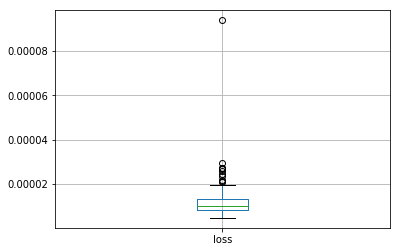

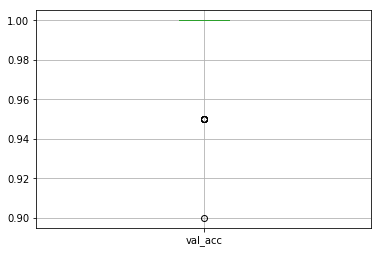

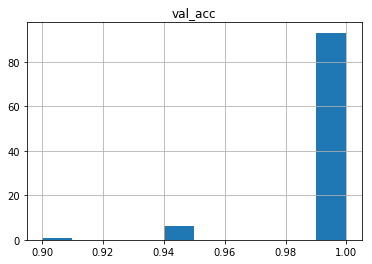

In [45]:
file = '../logs/2018-12-22T15:54/GunPoint/resnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
accuracy = data.iloc[:,2]
print(data.describe())
print('Accuracy mean and 95% confidence level is', accuracy.mean(), accuracy.std()*1.96)
print('95% confidence interval is', accuracy.quantile(0.0025), 'to', accuracy.quantile(0.975))
plt.figure(0)
data.boxplot(column='loss')
plt.figure(1)
data.boxplot(column='val_acc')
data.hist(column='val_acc')
print('Rows with val_acc<1 are')
data[data.val_acc<0.99]

# Summary results

95% confidence :-

|Timestamp |Model |Mean val_acc | +/- | lower |  upper  | Comment
|:---|:--- |:---  |:---    |:----------      |:------------- |:-------------
|2018-12-01T08:43  |MLP  |0.9715 | 0.0727 |0.8500 |1.0  | 10-fold, 10 resamples |
|2018-12-22T15:54  |ResNet  |0.9960 | 0.0301 | 0.9124 |1.0  | 10-fold, 10 resamples |